In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from pylab import *
import json
#import cv2
import h5py
import imageio
from IPython.display import Image
import side

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

#from tensorflow.compat.v1.logging import INFO, set_verbosity

#set_verbosity(INFO)

K.set_image_data_format("channels_first")

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Num GPUs Available:  1
Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
tf.config.experimental.get_memory_growth(physical_device[0])

In [3]:
pwd

'c:\\Users\\ad\\Desktop\\JupyterNotebook'

In [2]:
# set home directory and data directory
HOME_DIR = "D:/DataSet/HeadSeg/"
Train_DIR = HOME_DIR + "train/"
Valid_DIR = HOME_DIR + "valid/"
Test_DIR = HOME_DIR + "test/"
DATA_DIR = HOME_DIR
HeadData_DIR = "D:/DataSet/HeadSeg/Raw_HeadSet/"
MRI_DIR = HeadData_DIR + "MRI/"
LABEL_DIR = HeadData_DIR + "Label/"

<a name="4"></a>
# 4 Create and Train the model 

In [3]:
def total_loss(y_true, y_pred, axis = (1, 2, 3), epsilon = 0.00001, gamma=2.0, alpha=0.25):  #combibnational loss with dice loss and focal loss

    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))


    """
    Compute focal loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        alpha: balancing factor, default to be 0.25
        gamma: focusing parameter, default to be 2.0
    Returns:
        focal_loss (float): computed value of dice loss.   
    """
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_loss = -K.mean(alpha * K.pow(1.0 - pt, gamma) * K.log(pt), axis=[0,1,2])
    
    total_loss = dice_loss + 1* focal_loss

    return total_loss

def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):#epsilon=0.00001
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))
 
    return dice_coefficient

In [4]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):#epsilon=0.00001

                   #axis=(1, 2, 3), 
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))

    return dice_loss

def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):#epsilon=0.00001
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))
 
    return dice_coefficient


In [4]:
def create_convolution_block(input_layer, n_filters, batch_normalization= False,
                             kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1),
                             instance_normalization=False):
    """
    :param strides:
    :param input_layer:
    :param n_filters:
    :param batch_normalization:
    :param kernel:
    :param activation: Keras activation layer to use. (default is 'relu')
    :param padding:
    :return:
    """
    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(
        input_layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)
    
def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2),
                       strides=(2, 2, 2),
                       deconvolution=False):
    if deconvolution:
        return Conv3DTranspose(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)

In [5]:
def unet_model_3D(loss_function, input_shape=(1, 80, 80, 64),
                  pool_size=(2, 2, 2), n_labels=5,
                  initial_learning_rate=0.00001,
                  deconvolution=False, depth=5, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[],
                  batch_normalization=False, activation_name="sigmoid"): 

    """
    Builds the 3D UNet Keras model.f
    :param metrics: List metrics to be calculated during model training (default is dice coefficient).
    :param include_label_wise_dice_coefficients: If True and n_labels is greater than 1, model will report the dice
    coefficient for each label as metric.
    :param n_base_filters: The number of filters that the first layer in the convolution network will have. Following
    layers will contain a multiple of this number. Lowering this number will likely reduce the amount of memory required
    to train the model.
    :param depth: indicates the depth of the U-shape for the model. The greater the depth, the more max pooling
    layers will be added to the model. Lowering the depth may reduce the amount of memory required for training.
    :param input_shape: Shape of the input data (n_chanels, x_size, y_size, z_size). The x, y, and z sizes must be
    divisible by the pool size to the power of the depth of the UNet, that is pool_size^depth.
    :param pool_size: Pool size for the max pooling operations.
    :param n_labels: Number of binary labels that the model is learning.
    :param initial_learning_rate: Initial learning rate for the model. This will be decayed during training.
    :param deconvolution: If set to True, will use transpose convolution(deconvolution) instead of up-sampling. This
    increases the amount memory required during training.
    :return: Untrained 3D UNet Model
    """
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth),
                                          batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth) * 2,
                                          batch_normalization=batch_normalization)
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth - 2, -1, -1):
        
        #print(K.int_shape(current_layer)[1])
        up_convolution = get_up_convolution(pool_size=pool_size,
                                            deconvolution=deconvolution,
                                            n_filters=K.int_shape(current_layer)[1])(current_layer)
        
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        
        #print(K.int_shape(levels[layer_depth][1])[1])
        current_layer = create_convolution_block(n_filters= K.int_shape(levels[layer_depth][1])[1],
                                                 input_layer=concat, 
                                                 batch_normalization=batch_normalization)
        
        current_layer = create_convolution_block(n_filters= K.int_shape(levels[layer_depth][1])[1],
                                                 input_layer=current_layer,
                                                 batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss=loss_function,
                  metrics=metrics)
    return model

In [6]:
model_3D = unet_model_3D(depth=5,loss_function=total_loss, metrics=[dice_coefficient])

In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(model_3D, to_file='3D_U-Net_Model.png')

<a name="4-1"></a>
## 4.1 Training on a Large Dataset

In order to facilitate the training on the large dataset:
- We have pre-processed the entire dataset into patches and stored the patches in the [`h5py`](http://docs.h5py.org/en/stable/) format. 
- We also wrote a custom Keras [`Sequence`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence) class which can be used as a `Generator` for the keras model to train on large datasets. 

To get a flavor of the training on the larger dataset, you can run the following cell to train the model on a small subset of the dataset (85 patches). You should see the loss going down and the dice coefficient going up. 

Running `model.fit()` on the Coursera workspace may cause the kernel to die.
- Soon, we will load a pre-trained version of this model, so that you don't need to train the model on this workspace.

In [7]:
base_dir = DATA_DIR
#base_dir = "./BraTS-Data/processed/"
#with open(base_dir + "config.json") as json_file:
with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)
    
print(len(config["train"]),len(config["valid"]))


775 150


Generate Data for Training Set

# Initialization
num_channels = 1
num_classes = 5
dim = (160,160,16)
X_train = np.zeros((len(config["train"]), num_channels, *dim),
             dtype=np.float64) #float64
y_train = np.zeros((len(config["train"]), num_classes, *dim),
             dtype=np.float64) #float64
# Generate data

#base_dir = "./BraTS-Data/processed/"
directory_train = base_dir + "train/"
print(directory_train)

for i,ID in enumerate(config["train"]):
    # Store sample
    with h5py.File(directory_train + ID, 'r') as f:
        X_train[i] = np.array(f.get("x"))
        y_train[i] = np.array(f.get("y"))

print(X_train.shape)
print(y_train.shape)

Generate Data for Validation Set

# Initialization
num_channels = 1
num_classes = 5
dim = (160,160,16)
X_valid = np.zeros((len(config["valid"]), num_channels, *dim),
             dtype=np.float64)
y_valid = np.zeros((len(config["valid"]), num_classes, *dim),
             dtype=np.float64)

# Generate data
base_dir = DATA_DIR
directory_valid = base_dir + "valid/"
print(directory_valid)

for i,ID in enumerate(config["valid"]):
    # Store sample
    #print(directory_valid+ ID)
    with h5py.File(directory_valid + ID, 'r') as f:
        X_valid[i] = np.array(f.get("x"))
        y_valid[i] = np.array(f.get("y"))
        
        #print(i)

print(X_valid.shape)
print(y_valid.shape)

In [9]:
class VolumeDataGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                sample_list,
                 base_dir,
                 batch_size=1,
                 shuffle=True,
                 dim=(80, 80, 64),
                 num_channels=1,
                 num_classes=5,
                 verbose=1):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.dim = dim
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.verbose = verbose
        self.sample_list = sample_list
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.sample_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.sample_list) / self.batch_size))
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size, self.num_channels, *self.dim),
                     dtype=np.float32) #np.float64
        y = np.zeros((self.batch_size, self.num_classes, *self.dim),
                     dtype=np.float32) #np.float64
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.verbose == 1:
                print("Training on: %s" % self.base_dir + ID)
            with h5py.File(self.base_dir + ID, 'r') as f:
                a = np.array(f.get("x"))
                X[i]=scaler.fit_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape)
                y[i] = np.array(f.get("y"))
        return X, y
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[
                  index * self.batch_size: (index + 1) * self.batch_size]
        # Find list of IDs
        sample_list_temp = [self.sample_list[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(sample_list_temp)

        return X, y
 

In [8]:
# Get generators for training and validation sets
batch_size = 1
base_dir = DATA_DIR
#base_dir = "./BraTS-Data/processed/"
#with open(base_dir + "config.json") as json_file:
with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)
    
print(len(config["train"]),len(config["valid"]))

import side
train_generator = side.VolumeDataGenerator(config["train"], base_dir + "train/", batch_size=batch_size, dim=(80, 80, 64), verbose=0)
valid_generator = side.VolumeDataGenerator(config["valid"], base_dir + "valid/", batch_size=batch_size, dim=(80, 80, 64), verbose=0)


775 150


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint,  LearningRateScheduler
import os

# 儲存權重的路徑和檔名
# set the directory path to save the model weights
save_dir = HOME_DIR + "weights/"

# set the filename pattern for the model weights
filename = "Seg_weights_depth5_focal-{epoch:02d}_50.hdf5"

# set the full filepath for the model weights
filepath = os.path.join(save_dir, filename)

# 建立 ModelCheckpoint 回調函數
# 訓練模型時使用 callbacks 參數指定 ModelCheckpoint 回調函數
#model.fit_generator(
#    train_gen, steps_per_epoch=train_steps,
#    validation_data=val_gen, validation_steps=val_steps,
#    epochs=100, callbacks=[checkpoint]
#)
checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=True, mode='auto', save_freq='epoch', period=5
)

def lr_schedule(epoch):
    if epoch < 30:
        return 0.001
    if epoch < 60:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(lr_schedule)

In [12]:
steps_per_epoch = len(config["train"])/batch_size
n_epochs=100
validation_steps = len(config["valid"])/batch_size

history = model_3D.fit(x=train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        use_multiprocessing=True,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        verbose=1,
        callbacks=[checkpoint]
        )

#history = model_3D.fit(x=train_generator,
#        steps_per_epoch=steps_per_epoch,
#        epochs=n_epochs,
#        class_weight =class_weights,
#        use_multiprocessing=True,
#        validation_data=valid_generator,
#        validation_steps=validation_steps,
#        verbose=1,
#        callbacks=[checkpoint]
#        )

#save the training results
model_3D.save_weights(HOME_DIR + 'Seg_model_depth5_focal_100epochs.hdf5')

#Model.fit(
#    x=None,
#    y=None,
#    batch_size=None,
#    epochs=1,
#    verbose="auto",
#    callbacks=None,
#    validation_split=0.0,
#    validation_data=None,
#    shuffle=True,
#    class_weight=None,
#    sample_weight=None,
#    initial_epoch=0,
#    steps_per_epoch=None,
#    validation_steps=None,
#    validation_batch_size=None,
#    validation_freq=1,
#    max_queue_size=10,
#    workers=1,
#    use_multiprocessing=False,
#)


Epoch 1/100
775/775 [==============================] - 1089s 1s/step - loss: 0.5452 - dice_coefficient: 0.3206 - val_loss: 0.4842 - val_dice_coefficient: 0.3955
Epoch 2/100
775/775 [==============================] - 1047s 1s/step - loss: 0.3654 - dice_coefficient: 0.5052 - val_loss: 0.3761 - val_dice_coefficient: 0.5021
Epoch 3/100
775/775 [==============================] - 1046s 1s/step - loss: 0.3019 - dice_coefficient: 0.5876 - val_loss: 0.3543 - val_dice_coefficient: 0.5217
Epoch 4/100
775/775 [==============================] - 1054s 1s/step - loss: 0.2630 - dice_coefficient: 0.6393 - val_loss: 0.3520 - val_dice_coefficient: 0.5335
Epoch 5/100
775/775 [==============================] - ETA: 0s - loss: 0.2148 - dice_coefficient: 0.6861
Epoch 5: saving model to D:/DataSet/HeadSeg/weights\Seg_weights_depth5_focal-05_50.hdf5
775/775 [==============================] - 1047s 1s/step - loss: 0.2148 - dice_coefficient: 0.6861 - val_loss: 0.2227 - val_dice_coefficient: 0.6405
Epoch 6/100
77

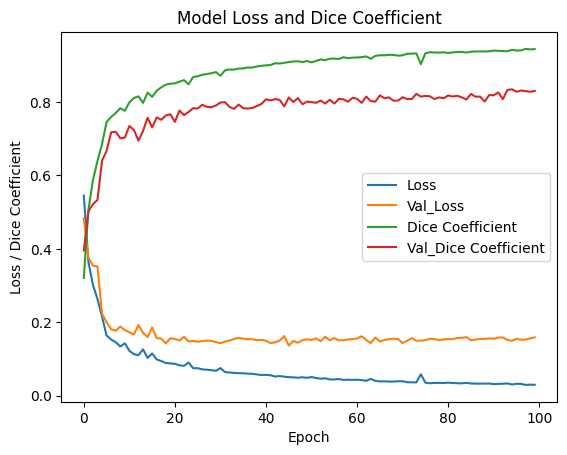

In [13]:
# Plot the training loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])

# Add labels and title
plt.title('Model Loss and Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Loss / Dice Coefficient')
plt.legend(['Loss', 'Val_Loss', 'Dice Coefficient', 'Val_Dice Coefficient'], loc='center right')

# Show the plot
plt.show()

## Load weights if needed


In [8]:
HOME_DIR = "D:/DataSet/HeadSeg/"
Weights_DIR = HOME_DIR + "weights/"

In [9]:
from tensorflow.keras.models import load_model
weights = model_3D.load_weights(Weights_DIR + "Seg_model_100epochs.hdf5")

## Get sub-volumes from 7th Headset for prediction

In [14]:

volume_list = os.listdir(Test_DIR)

#for n in range(len(volume_list)):
#    print("Volume name for predict: " + volume_list[n])
#    d = Test_DIR + f"{volume_list[n]}"
#    with h5py.File(d, 'r') as f:
#        img = np.array(f.get("x"))
#        msk = np.array(f.get("y"))

n = np.random.randint(0, len(volume_list))

print("Volume name for predict: " + volume_list[n])

d = Test_DIR + f"{volume_list[n]}"
with h5py.File(d, 'r') as f:
    img = np.array(f.get("x"))
    msk = np.array(f.get("y"))

print(img.shape)
print(msk.shape)


Volume name for predict: NIFTI_7.nii_x_40_y_80_z_96_.h5
(1, 80, 80, 64)
(5, 80, 80, 64)


In [15]:
Test_volume = np.expand_dims(img, axis=0)
patch_pred = model_3D.predict(Test_volume)
print(Test_volume.shape)
print(patch_pred.shape)

1/1 [==============================] - 1s 579ms/step
(1, 1, 80, 80, 64)
(1, 5, 80, 80, 64)


In [16]:
# set threshold.
threshold = 0.5

## use threshold to get hard predictions
#patch_pred[patch_pred > threshold] = 1.0
#patch_pred[patch_pred <= threshold] = 0.0

# use threshold to get hard predictions
pred_patch=np.zeros(patch_pred.shape)
pred_patch[patch_pred > threshold] = 1.0
pred_patch[patch_pred <= threshold] = 0.0

## Verify IoU on a batch of images from the test dataset

## Using built in keras function for IoU

Mean Intersection-Over-Union is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes. 

IOU is defined as follows: IOU = true_positive / (true_positive + false_positive + false_negative). 

The predictions are accumulated in a confusion matrix, weighted by sample_weight and the metric is then calculated from it.



In [17]:
from keras.metrics import MeanIoU

pred = pred_patch[0, :, :, :, :]
#print(pred.shape)
test_mask_argmax = np.argmax(msk, axis = 0)
test_pred_argmax = np.argmax(pred, axis = 0)

n_classes = 5
IOU_keras = MeanIoU(num_classes= n_classes)
IOU_keras.update_state(test_pred_argmax, test_mask_argmax)
print("Overall Mean IoU(Accuracy) = ", IOU_keras.result().numpy())

Tissue = ["Skin", "Skull", "CSF", "GM", "WM"] 

for i in range(n_classes):
    IOU_keras.reset_states()
    class_mask = np.equal(test_mask_argmax, i)
    class_pred = np.equal(test_pred_argmax, i)
    IOU_keras.update_state(class_mask, class_pred)
    print(f"{Tissue[i]} IoU(Accuracy) = "  ,IOU_keras.result().numpy())


Overall Mean IoU(Accuracy) =  0.62819606
Skin IoU(Accuracy) =  0.9129189
Skull IoU(Accuracy) =  0.7995684
CSF IoU(Accuracy) =  0.73896194
GM IoU(Accuracy) =  0.6816342
WM IoU(Accuracy) =  0.73805493


index on xy plane: 33


Text(0.5, 1.0, 'White Matter_Prediction')

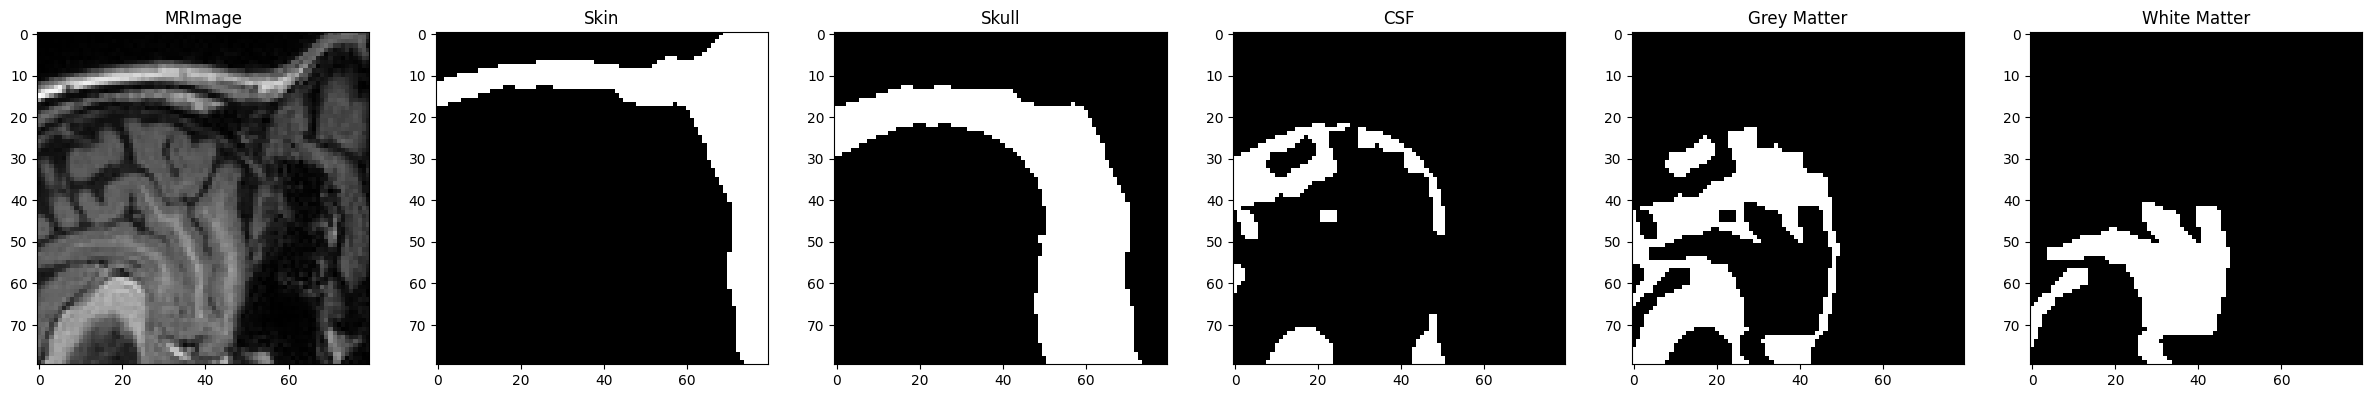

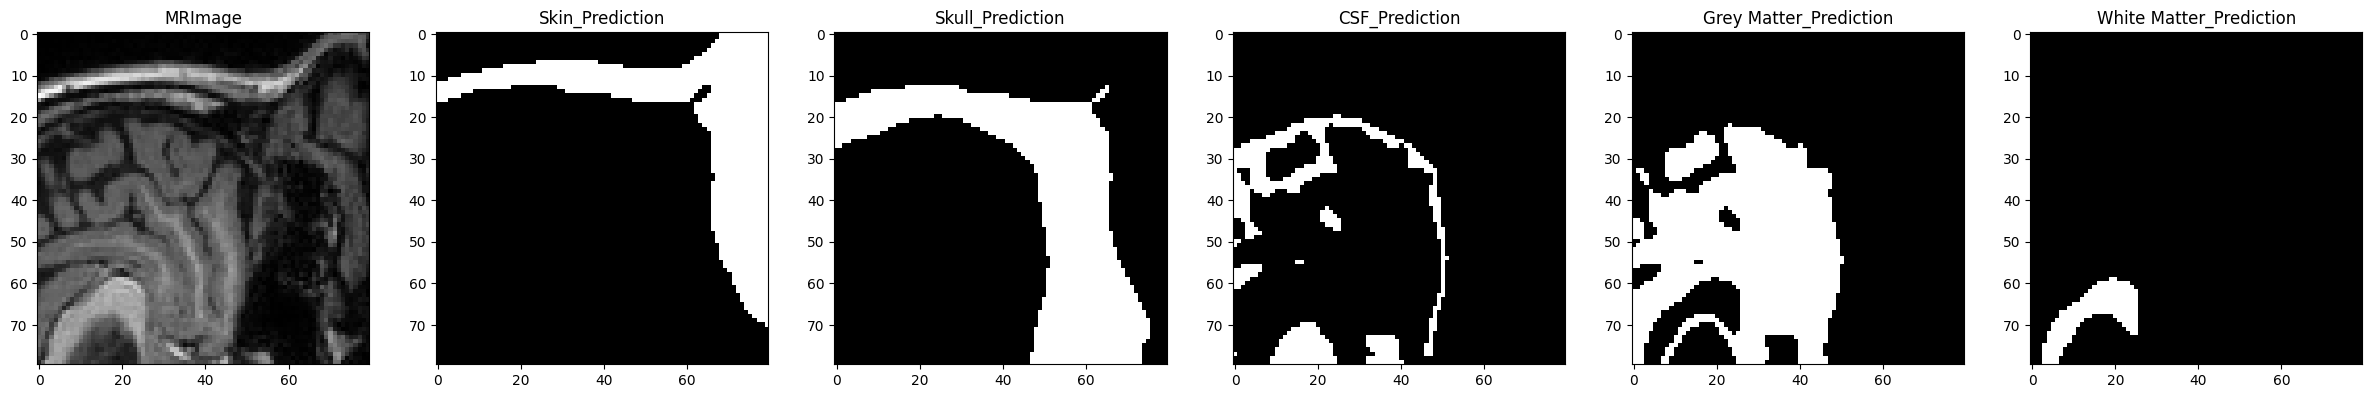

In [18]:
index = np.random.randint(0, 63)
index = 33
print(f"index on xy plane: {index}")

fig, ax = plt.subplots(1, 6, figsize=[30, 30], squeeze=False)
ax[0][0].imshow(img[0, : ,:, i], cmap='Greys_r')
ax[0][0].set_title("MRImage")

ax[0][1].imshow(msk[0, :, :, i], cmap='Greys_r')
ax[0][1].set_title("Skin")

ax[0][2].imshow(msk[1, :, :, i], cmap='Greys_r')
ax[0][2].set_title("Skull")

ax[0][3].imshow(msk[2, :, :, i], cmap='Greys_r')
ax[0][3].set_title("CSF")

ax[0][4].imshow(msk[3, :, :, i], cmap='Greys_r')
ax[0][4].set_title("Grey Matter")

ax[0][5].imshow(msk[4, :, :, i], cmap='Greys_r')
ax[0][5].set_title("White Matter")


fig, ax = plt.subplots(1, 6, figsize=[30, 30], squeeze=False)
ax[0][0].imshow(Test_volume[0, 0, : ,:, i], cmap='Greys_r')
ax[0][0].set_title("MRImage")

ax[0][1].imshow(pred_patch[0, 0, :, :, i], cmap='Greys_r')
ax[0][1].set_title("Skin_Prediction")

ax[0][2].imshow(pred_patch[0, 1, :, :, i], cmap='Greys_r')
ax[0][2].set_title("Skull_Prediction")

ax[0][3].imshow(pred_patch[0, 2, :, :, i], cmap='Greys_r')
ax[0][3].set_title("CSF_Prediction")

ax[0][4].imshow(pred_patch[0, 3, :, :, i], cmap='Greys_r')
ax[0][4].set_title("Grey Matter_Prediction")

ax[0][5].imshow(pred_patch[0, 4, :, :, i], cmap='Greys_r')
ax[0][5].set_title("White Matter_Prediction")


In [19]:
MRI_list = os.listdir(MRI_DIR)
Label_list = os.listdir(LABEL_DIR)
print(MRI_list)
print(Label_list)

['NIFTI_1.nii', 'NIFTI_2.nii', 'NIFTI_3.nii', 'NIFTI_4.nii', 'NIFTI_5.nii', 'NIFTI_6.nii', 'NIFTI_7.nii']
['Label_1.nii', 'Label_2.nii', 'Label_3.nii', 'Label_4.nii', 'Label_5.nii', 'Label_6.nii', 'Label_7.nii']


In [20]:
orig_x = 240
orig_y = 240
orig_z = 192
output_x = 80
output_y = 80
output_z = 64
num_classes = 6

orig_volume = np.zeros((orig_x, orig_y, orig_z))


filename = MRI_list[6]
img=np.array(nib.load(MRI_DIR + MRI_list[6]).get_fdata())
msk=np.array(nib.load(LABEL_DIR + Label_list[6]).get_fdata())
img_scale=scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

#Reshape to 240x240x192
image = img_scale[0:240, 5:245, :]
label = msk[0:240, 5:245, :]

    # Initialize features and labels with `None`
X = None
Y = None

for x in range(0, orig_x, output_x):
    for y in range(0, orig_y, output_y):
        for z in range(0, orig_z, output_z):

            start_x = x
            start_y = y
            start_z = z

            Y = label[start_x: start_x + output_x,start_y: start_y + output_y,start_z: start_z + output_z]
                
            Y = keras.utils.to_categorical(Y, num_classes=num_classes)

            X = np.copy(image[start_x: start_x + output_x,
                            start_y: start_y + output_y,
                            start_z: start_z + output_z])
            
                # change dimension of X
                # from (x_dim, y_dim, z_dim, num_channels)
                # to (num_channels, x_dim, y_dim, z_dim)
            X = np.expand_dims(X, axis=0)

            
                
                # change dimension of y
                # from (x_dim, y_dim, z_dim, num_classes)
                # to (num_classes, x_dim, y_dim, z_dim)
            Y = np.moveaxis(Y, 3, 0)

                #excludes the background class
            Y = Y[1:, :, :, :]

            Test_volume = np.expand_dims(X, axis=0)
            patch_pred = model_3D.predict(Test_volume)
            #print(Test_volume.shape)
            #print(patch_pred.shape)

            # set threshold.
            threshold = 0.5

            # use threshold to get hard predictions
            pred_patch=np.zeros(patch_pred.shape)
            pred_patch[patch_pred > threshold] = 1.0
            pred_patch[patch_pred <= threshold] = 0.0

            pred = pred_patch[0, :, :, :, :]

            zeros_array = np.zeros((1, 80, 80, 64))
            pred = np.concatenate((zeros_array, pred), axis=0)
            #print(pred.shape)

            test_pred_argmax = np.argmax(pred, axis = 0)
            #print(test_pred_argmax.shape)
            orig_volume[start_x: start_x + output_x,start_y: start_y + output_y,start_z: start_z + output_z] = test_pred_argmax

1/1 [==============================] - 0s 27ms/step


In [21]:
num_classes = 6

truth = keras.utils.to_categorical(label, num_classes = num_classes)
predict_label = keras.utils.to_categorical(orig_volume, num_classes = num_classes)

truth = np.moveaxis(truth, 3, 0)
predict_label = np.moveaxis(predict_label, 3, 0)

index on xy plane: 90


Text(0.5, 1.0, 'White Matter_Prediction')

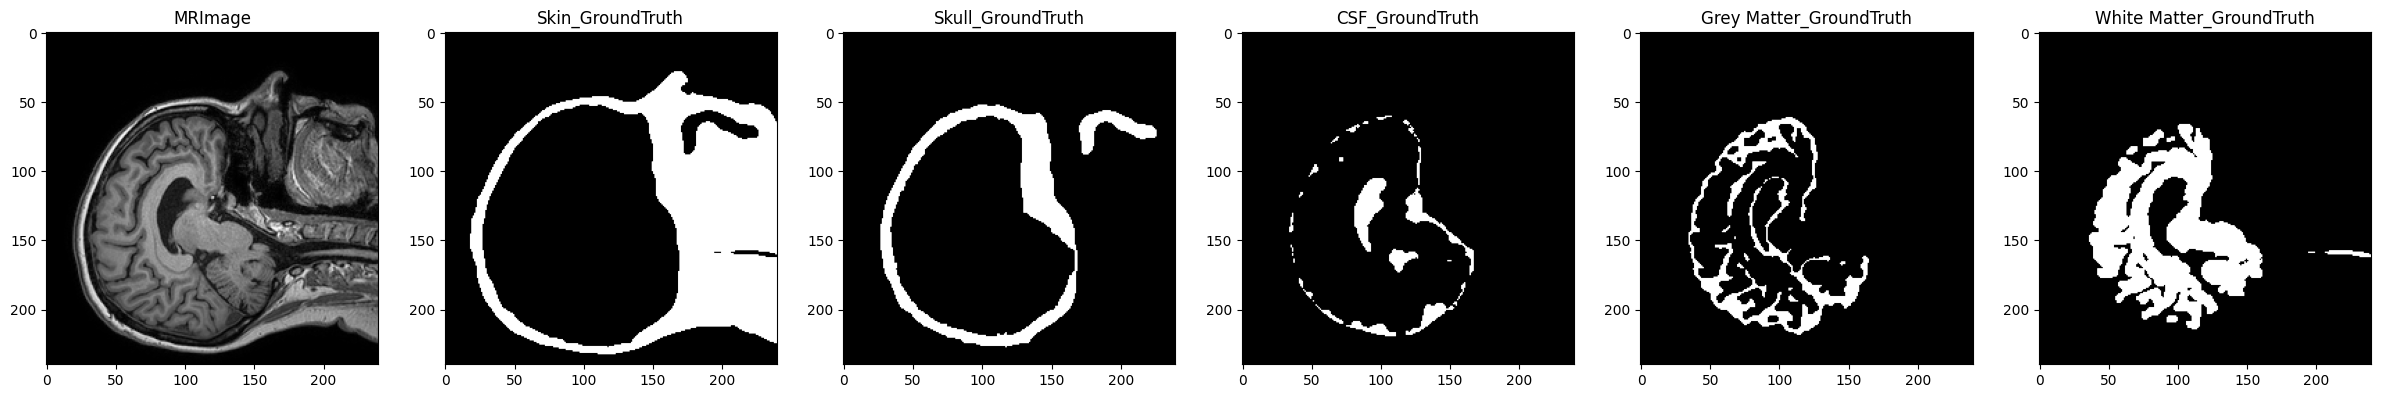

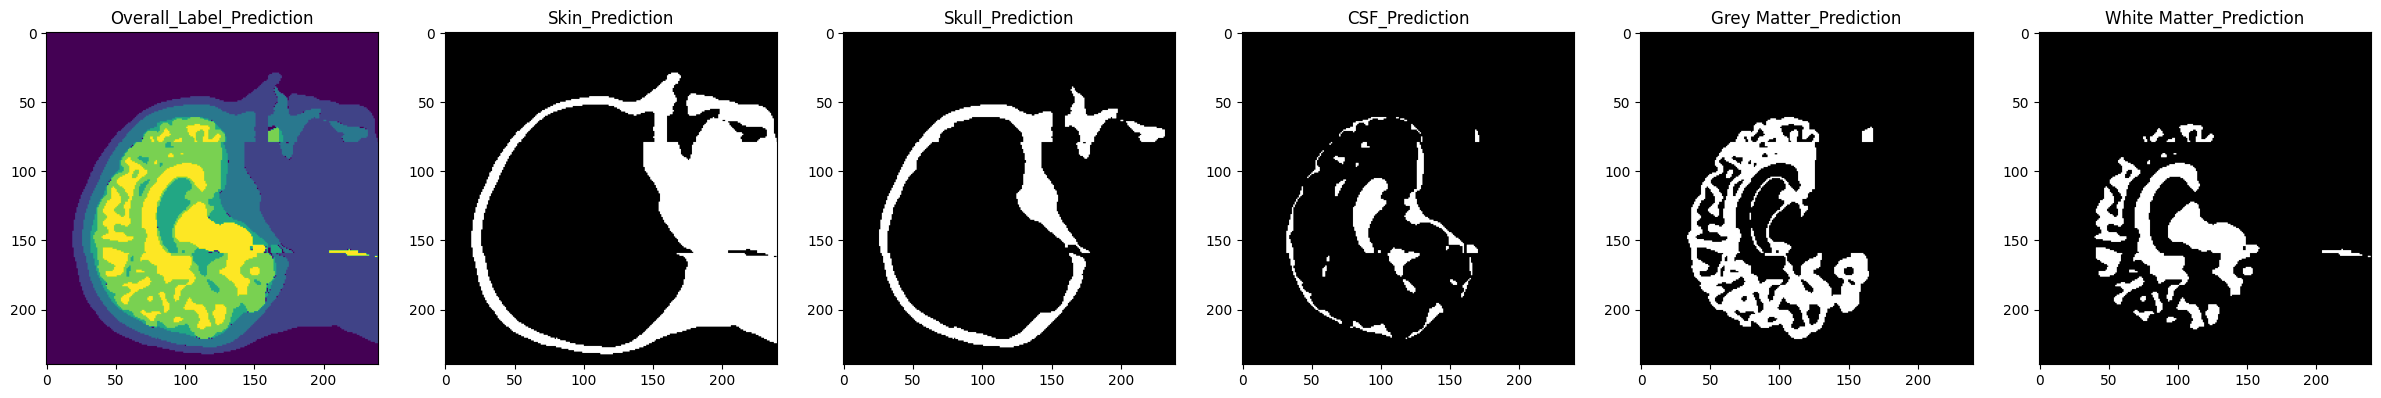

In [22]:
index = 90
#index = np.random.randint(0,191)
print(f"index on xy plane: {index}")

fig, ax = plt.subplots(1, 6, figsize=[30, 30], squeeze=False)
ax[0][0].imshow(image[: ,:, index], cmap='Greys_r')
ax[0][0].set_title("MRImage")

ax[0][1].imshow(truth[1, :, :, index], cmap='Greys_r')
ax[0][1].set_title("Skin_GroundTruth")

ax[0][2].imshow(truth[2, :, :, index], cmap='Greys_r')
ax[0][2].set_title("Skull_GroundTruth")

ax[0][3].imshow(truth[3, :, :, index], cmap='Greys_r')
ax[0][3].set_title("CSF_GroundTruth")

ax[0][4].imshow(truth[4, :, :, index], cmap='Greys_r')
ax[0][4].set_title("Grey Matter_GroundTruth")

ax[0][5].imshow(truth[5, :, :, index], cmap='Greys_r')
ax[0][5].set_title("White Matter_GroundTruth")


fig, ax = plt.subplots(1, 6, figsize=[30, 30], squeeze=False)
ax[0][0].imshow(orig_volume[: ,:, index])
ax[0][0].set_title("Overall_Label_Prediction")

ax[0][1].imshow(predict_label[1, :, :, index], cmap='Greys_r')
ax[0][1].set_title("Skin_Prediction")

ax[0][2].imshow(predict_label[2, :, :, index], cmap='Greys_r')
ax[0][2].set_title("Skull_Prediction")

ax[0][3].imshow(predict_label[3, :, :, index], cmap='Greys_r')
ax[0][3].set_title("CSF_Prediction")

ax[0][4].imshow(predict_label[4, :, :, index], cmap='Greys_r')
ax[0][4].set_title("Grey Matter_Prediction")

ax[0][5].imshow(predict_label[5, :, :, index], cmap='Greys_r')
ax[0][5].set_title("White Matter_Prediction")

In [23]:
from keras.metrics import MeanIoU

pred = pred_patch[0, :, :, :, :]
#print(pred.shape)
test_mask_argmax = label
test_pred_argmax = orig_volume

n_classes = 6
IOU_keras = MeanIoU(num_classes= n_classes)
IOU_keras.update_state(test_mask_argmax, test_pred_argmax)
print("Overall Mean IoU(Accuracy) = ", IOU_keras.result().numpy())

Tissue = ["Background", "Skin", "Skull", "CSF", "GM", "WM"] 

for i in range(1, 6):
    IOU_keras.reset_states()
    class_mask = np.equal(test_mask_argmax, i)
    class_pred = np.equal(test_pred_argmax, i)
    IOU_keras.update_state(class_mask, class_pred)
    print(f"{Tissue[i]} IoU(Accuracy) = "  ,IOU_keras.result().numpy())

Overall Mean IoU(Accuracy) =  0.68727
Skin IoU(Accuracy) =  0.9370748
Skull IoU(Accuracy) =  0.8089333
CSF IoU(Accuracy) =  0.7320999
GM IoU(Accuracy) =  0.73751616
WM IoU(Accuracy) =  0.79189456


In [168]:
pwd

'c:\\Users\\ad\\Desktop\\JupyterNotebook'

In [34]:
import nibabel as nib

nii = nib.Nifti1Image(orig_volume, affine=None)

nib.save(nii, 'pred_result.nii')
